# Инициализация необходимых функций/классов

In [43]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


# Создадим переменные для последующей быстрой передачи
mnist_train, mnist_test = get_mnist_loaders()

In [45]:
# trainer 
import torch.optim as optim
from tqdm import tqdm


def run_epoch(model, data_loader, criterion, optimizer=None, device='cuda:0', is_test=False, l2_alpha=0.001):
    if is_test:
        model.eval()
    else:
        model.train()

    model = model.to(device)
    
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # print(f'Epoch {epoch+1}/{epochs}:')
        # print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        # print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        # print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 


In [210]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleResNet(nn.Module):
    def __init__(self, in_channels=1,  num_classes=10):
        super().__init__()
                # Residual блок
        self.layer1 = ResidualBlock(in_channels, 64, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(2, 2)    # 28x28 --> 14x14
        self.fc = nn.Linear(64*14*14, num_classes)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)               
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)          
        return x


class CNN(nn.Module):
    def __init__(self, config_path=None, input_channels=1, num_classes=10, **kwargs):
        super().__init__()
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs
        
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.layers, fc_input_size = self._build_layers()
        self.linear = nn.Linear(fc_input_size, self.num_classes)
    
    def load_config(self, config_path):
        """Загружает конфигурацию из JSON файла"""
        with open(config_path, 'r') as f:
            return json.load(f)
    
    def _build_layers(self):
        layers = []
        current_channels = self.input_channels
        spatial_size = 28  # MNIST 28x28
        
        layer_config = self.config.get('layers', [])
        
        for layer_spec in layer_config:
            layer_type = layer_spec['type']
            
            if layer_type == 'Con2d':
                out_channels = layer_spec['size']
                kernel = layer_spec['kernel']
                layers.append(nn.Conv2d(current_channels, out_channels, kernel_size=kernel, padding=1))
                current_channels = out_channels
                
            elif layer_type == 'relu':
                layers.append(nn.ReLU())

            elif layer_type == 'maxpool':
                kernel = layer_spec['kernel']
                layers.append(nn.MaxPool2d(kernel))
                spatial_size = spatial_size // kernel
                
            elif layer_type == 'dropout':
                rate = layer_spec.get('rate', 0.5)
                layers.append(nn.Dropout(rate))
        
        # Вычисляем размер для linear
        fc_input_size = current_channels * spatial_size * spatial_size
        
        return nn.Sequential(*layers), fc_input_size
    
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1) 
        x = self.linear(x)
        return x

In [287]:
import torch
import matplotlib.pyplot as plt


def plot_training_history(history, model_name=''):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy ' + model_name)
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [307]:
#  Класс для визуализации 'feature maps' для каждого из слоев Conv2d
class FeatureMapExtractor:
    def __init__(self, model):
        self.feature_maps = {}
        self.hooks = []
        # Регистрируем хуки для всех Conv2d слоев
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d):
                self.hooks.append(
                    layer.register_forward_hook(
                        lambda m, inp, out, name=name: self.save_feature_map(name, out)
                    )
                )
    
    def save_feature_map(self, name, output):
        self.feature_maps[name] = output.detach().cpu()
    
    def visualize(self, sample_img):
        # Визуализация исходного изображения
        plt.imshow(sample_img.squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.show()
        
        # Визуализация карт признаков
        for name, maps in self.feature_maps.items():
            # print(f"Слой: {name} | Размер: {maps.shape}")
            
            # Показываем первые 4 feature maps
            maps = maps.squeeze(0)  # Удаляем batch-размер
            num_channels = min(4, maps.size(0))
            
            plt.figure(figsize=(12, 8))
            for i in range(num_channels):
                plt.subplot(1, 4, i+1)
                plt.imshow(maps[i])
                plt.axis('off')
            plt.suptitle(f"Карты признаков: {name}, {maps.shape}")
            plt.tight_layout()
            plt.show()


In [320]:
def plot_gradient_flow(model, data_loader,model_name='', device='cuda:0'):
    """Улучшенная визуализация градиентов с диагностикой"""
    model.train()
    model.to(device)
    
    # Сбрасываем градиенты
    for param in model.parameters():
        if param.grad is not None:
            param.grad.zero_()
    
    # Получаем один батч данных
    try:
        inputs, targets = next(iter(data_loader))
    except StopIteration:
        data_loader = iter(data_loader)
        inputs, targets = next(data_loader)
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward + backward pass
    outputs = model(inputs)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    
    # Собираем данные для графика
    grad_data = []
    layers = []
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            grad_mean = param.grad.abs().mean().item()
            grad_data.append(grad_mean)
            layers.append(name)
            print(f"Слой {name}: grad_mean = {grad_mean:.2e}")  # Диагностика
    
    # Визуализация
    plt.figure(figsize=(12, 12))
    plt.barh(layers, grad_data)
    plt.xscale('log')  # Логарифмическая шкала для лучшего отображения
    plt.xlabel("Среднее значение градиента (log scale)")
    plt.ylabel("Слои")
    plt.title(f"Анализ потока градиентов модели {model_name}")
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.show()



In [149]:
def count_parameters(model):
    """Подсчитывает количество параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [160]:
device = torch.device('cuda:0')

# Задание 2: Анализ архитектур CNN (30 баллов)


## 2.1 Влияние размера ядра свертки (15 баллов)


 Исследуйте влияние размера ядра свертки:
- 3x3 ядра
 - 5x5 ядра
 - 7x7 ядра
 - Комбинация разных размеров (1x1 + 3x3)
 
Для каждого варианта:
- Поддерживайте одинаковое количество параметров
 - Сравните точность и время обучения
   > Модели обучались примерно одинаково (по 3 минуты каждая, 10 эпох). У всех test_accr больше, чем train_accr + метрики у них одинаковые, хоть и разные графики
 - Проанализируйте рецептивные поля
 > При одинаковых размерах ядер у слоев размер рецептивного слоя увеличивается на 2 в каждом измерении (высота * ширина)
>  То есть первый слой считывает 3x3 область пикселей, второй слой смотрит своим ядром (3X3) на карту первого слоя -> отсюда смотрит на область 5x5 изображения
>Я создал в каждом по 3 слоя.
>> Ядро\
>>  3х3| 1 → 3 → 5 → 6 → 10	_10x10_\
    5x5|	1 → 5 → 9 → 10 → 18	_18x18_\
    7x7|	1 → 7 → 13 → 14 → 26	_26x26_\
    combine (1+3+5)|	1 → 1 → 3 → 4 → 12	_12x12_
>
>Имеем, что при kernel_size = 7x7 каждый пикслель в feature map на 3 слое обладает информации о 26x26 пикселей (при 28x28 MNIST - считай все изображение)
 - Визуализируйте активации первого слоя
   

In [82]:
# Создадим разные ядра
config3x3 = {
    "input_size": 1,
    "num_classes": 10,
    "layers": [
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 64, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel':2},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"}]} 
cnn3x3 = CNN(**config3x3)
###################

config5x5  = {
    "input_size": 1,
    "num_classes": 10,
    "layers": [
        {"type": "Con2d", "size": 32, 'kernel': 5},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 64, 'kernel': 5},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel':2},
        {"type": "Con2d", "size": 32, 'kernel': 5},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"}]}
cnn5x5 = CNN(**config5x5)
###################

config7x7  = {
    "input_size": 1,
    "num_classes": 10,
    "layers": [
        {"type": "Con2d", "size": 32, 'kernel': 7},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 64, 'kernel': 7},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel':2},
        {"type": "Con2d", "size": 32, 'kernel': 7},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"}]}
cnn7x7 = CNN(**config7x7)
###################

config_combine= {
    "input_size": 1,
    "num_classes": 10,
    "layers": [
        {"type": "Con2d", "size": 32, 'kernel': 1},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 64, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel':2},
        {"type": "Con2d", "size": 32, 'kernel': 5},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"}]}
cnn_combine = CNN(**config_combine)

In [90]:
k3x3 = train_model(cnn3x3, mnist_train, mnist_test, epochs=10)
k5x5 = train_model(cnn5x5, mnist_train, mnist_test, epochs=10)
k7x7 = train_model(cnn7x7, mnist_train, mnist_test, epochs=10)
k_combine = train_model(cnn_combine, mnist_train, mnist_test, epochs=10)

# Сохраним метрики
torch.save(k3x3, 'laba4/k3x3_metrcis.pt')
torch.save(k5x5, 'laba4/k5x5_metrcis.pt')
torch.save(k7x7, 'laba4/k7x7_metrcis.pt')
torch.save(k_combine, 'laba4/k_combine_metrcis.pt')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:09<00:00, 18.93s/it]


Accuracy k3x3:  Training: 0.83; test: 0.89


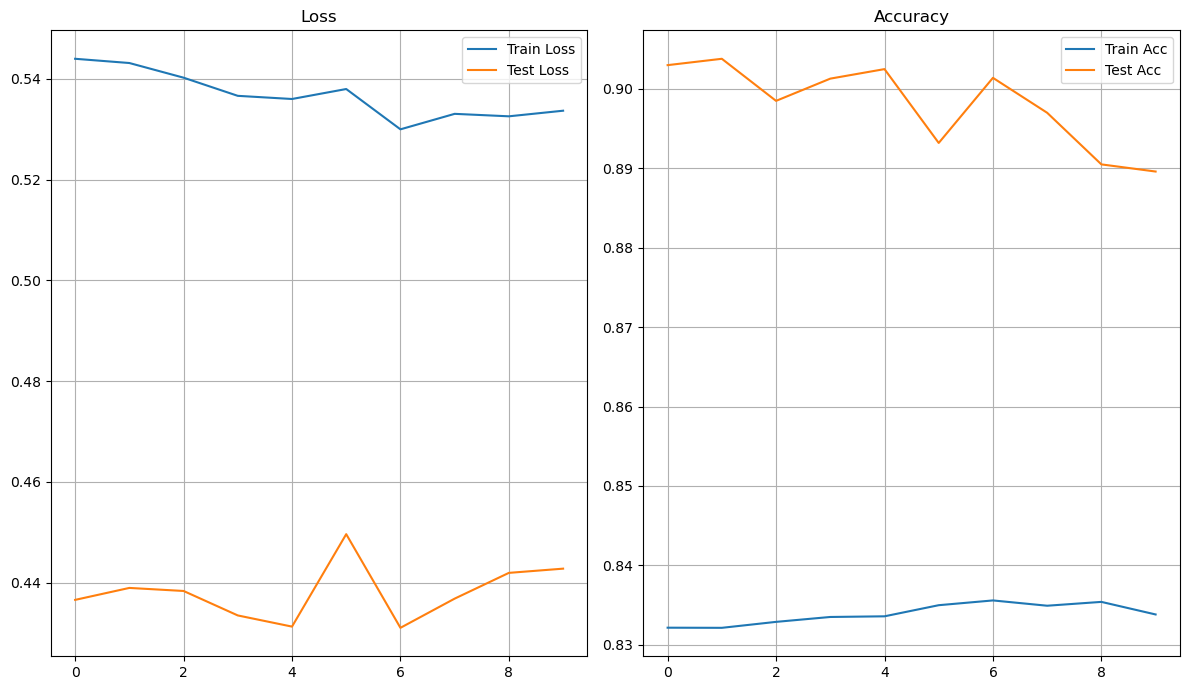

Accuracy k5x5:  Training: 0.83; test: 0.89


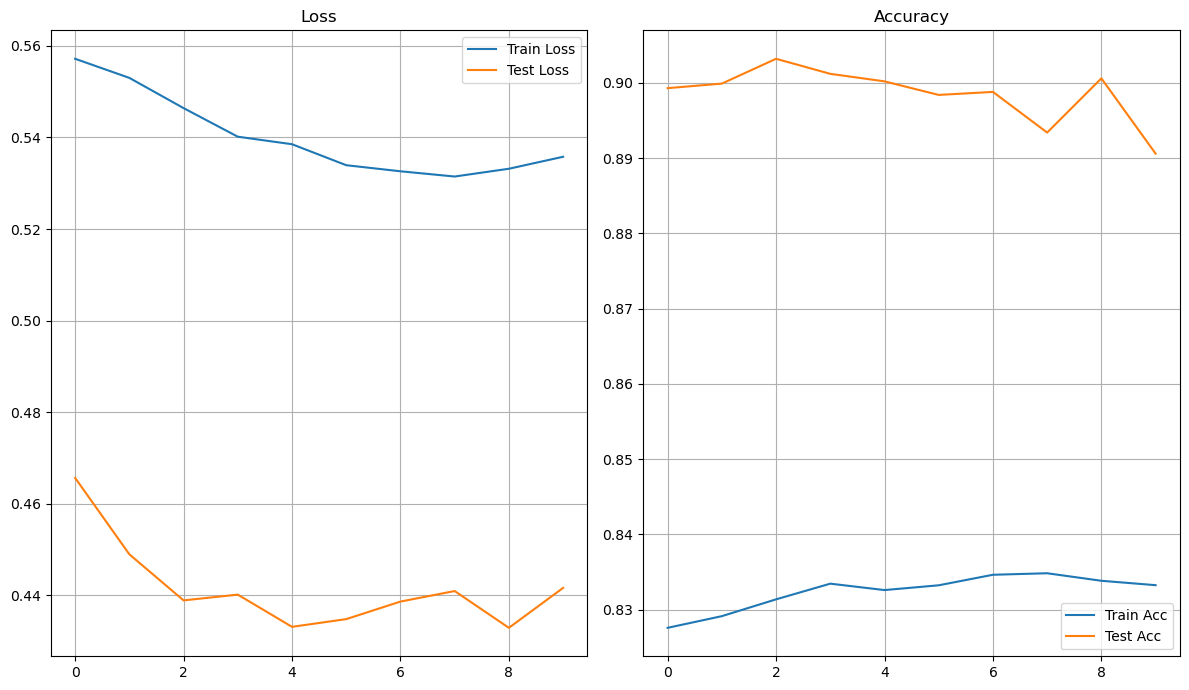

Accuracy k7x7:  Training: 0.83; test: 0.89


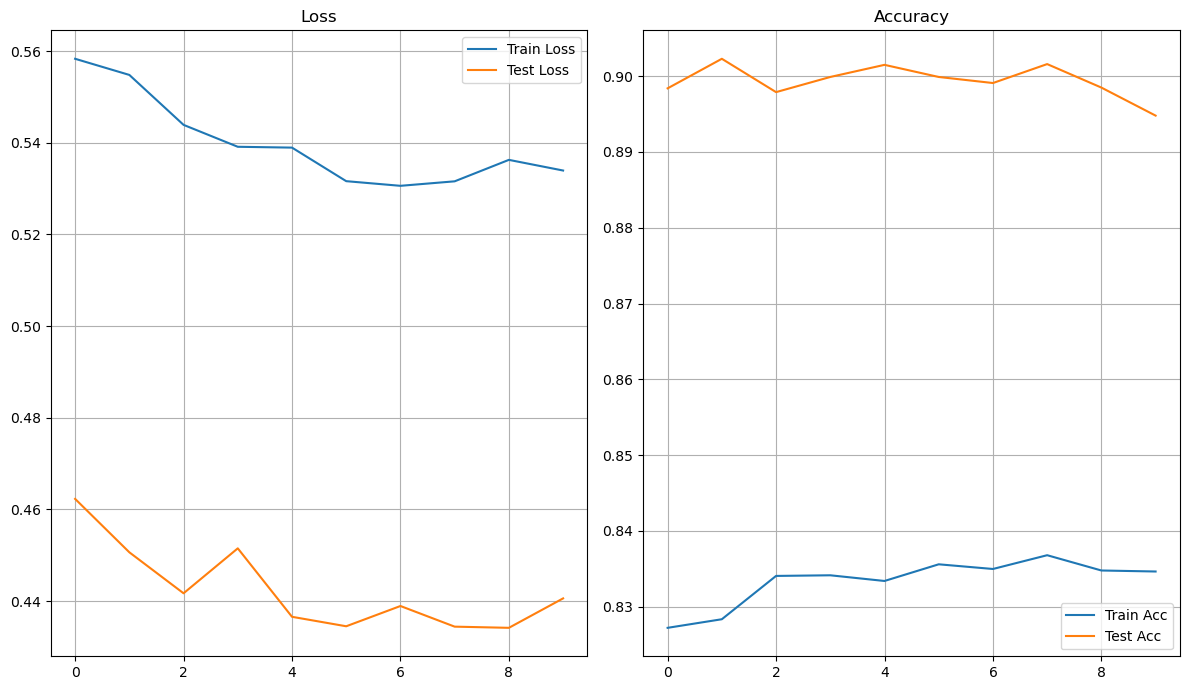

Accuracy k_combine:  Training: 0.84; test: 0.89


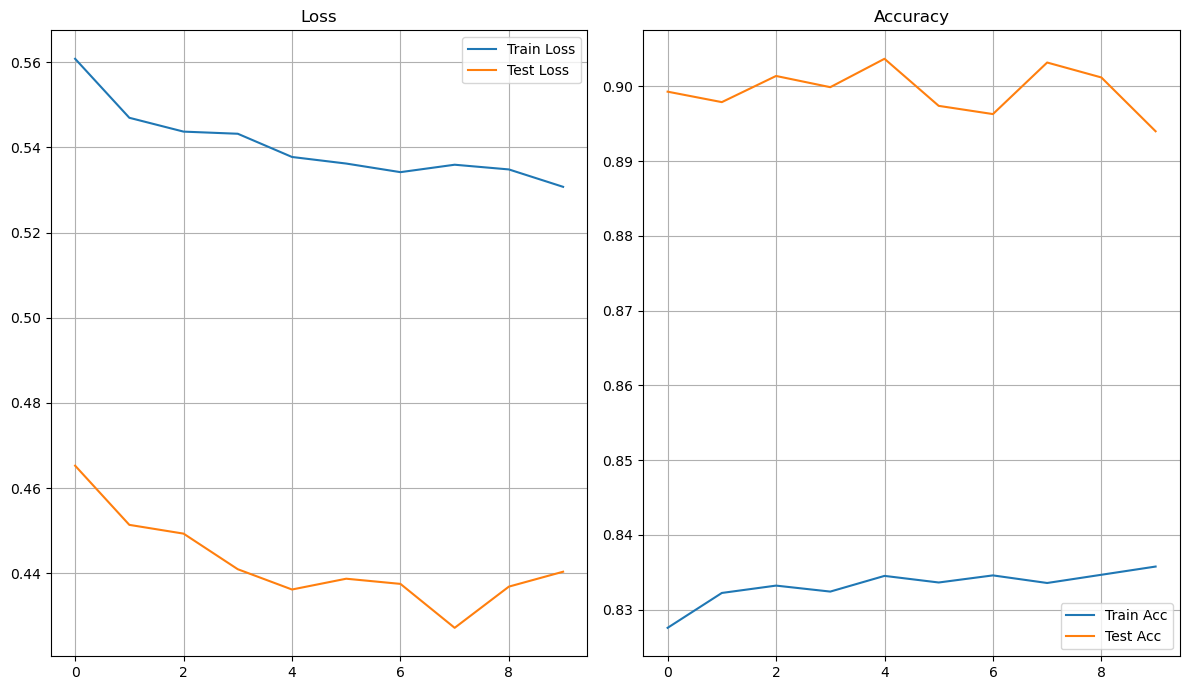

In [249]:
def mean_accr(metric):
    mean_train = metric['train_accs'][-1]
    mean_test = metric['test_accs'][-1]
    return f'Training: {mean_train:.2f}; test: {mean_test:.2f}'

print(f'Accuracy k3x3:  {mean_accr(k3x3)}')
plot_training_history(k3x3)

print(f'Accuracy k5x5:  {mean_accr(k5x5)}')
plot_training_history(k5x5)

print(f'Accuracy k7x7:  {mean_accr(k7x7)}')
plot_training_history(k7x7)

print(f'Accuracy k_combine:  {mean_accr(k_combine)}')
plot_training_history(k_combine)

# 2.2 Влияние глубины CNN (15 баллов)
 Исследуйте влияние глубины CNN:
 - Неглубокая CNN (2 conv слоя)
 - Средняя CNN (4 conv слоя)
 - Глубокая CNN (6+ conv слоев)
 - CNN с Residual связями
 
 Для каждого варианта:
 - Сравните точность и время обучения
 - Проанализируйте vanishing/exploding gradients
 - Исследуйте эффективность Residual связей
 - Визуализируйте feature maps

In [229]:
# Создаем конфиги для CNN
config_2layers = {
    "input_size": 1,
    "num_classes": 10,
    "layers": [
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"}]} 

config_4layers = {
    "input_size": 1,
    "num_classes": 10,
    "layers": [
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel': 2},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel': 2},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"}]} 

config_6layers = config_4layers = {
    "input_size": 1,
    "num_classes": 10,
    "layers": [
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel': 2},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "maxpool", 'kernel': 2},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"},
        {"type": "Con2d", "size": 32, 'kernel': 3},
        {'type': 'dropout', 'rate': 0.25},
        {"type": "relu"}]} 

In [231]:
cnn_tide = CNN(**config_2layers)
cnn_wide = CNN(**config_4layers)
cnn_deep = CNN(**config_6layers)
# resnet_cnn = SimpleResNet()

In [233]:
cnn_tide_metrics = train_model(cnn_tide, mnist_train, mnist_test, epochs=10)
cnn_wide_metrics = train_model(cnn_wide, mnist_train, mnist_test, epochs=10)
cnn_deep_metrics = train_model(cnn_deep, mnist_train, mnist_test, epochs=10)
# resnet_cnn_metrics = train_model(resnet_cnn, mnist_train, mnist_test, epochs=10)


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [18:46<00:00, 112.68s/it]


In [235]:
# Сохраним метрики
torch.save(cnn_tide_metrics, 'laba4/cnn_tide_metrcis.pt')
torch.save(cnn_wide_metrics, 'laba4/cnn_wide_metrcis.pt')
torch.save(cnn_deep_metrics, 'laba4/cnn_deep_metrcis.pt')
torch.save(resnet_cnn_metrics, 'laba4/resnet_cnn_metrcis.pt')

# Модели 
# torch.save(resnet_cnn, 'laba4/resnet_cnn.pt')
torch.save(cnn_tide, 'laba4/cnn_tide.pt')
torch.save(cnn_wide, 'laba4/cnn_wide.pt')
torch.save(cnn_deep, 'laba4/cnn_deep.pt')


Accuracy cnn_tide_metrics:  Training: 0.9960; test: 0.9868


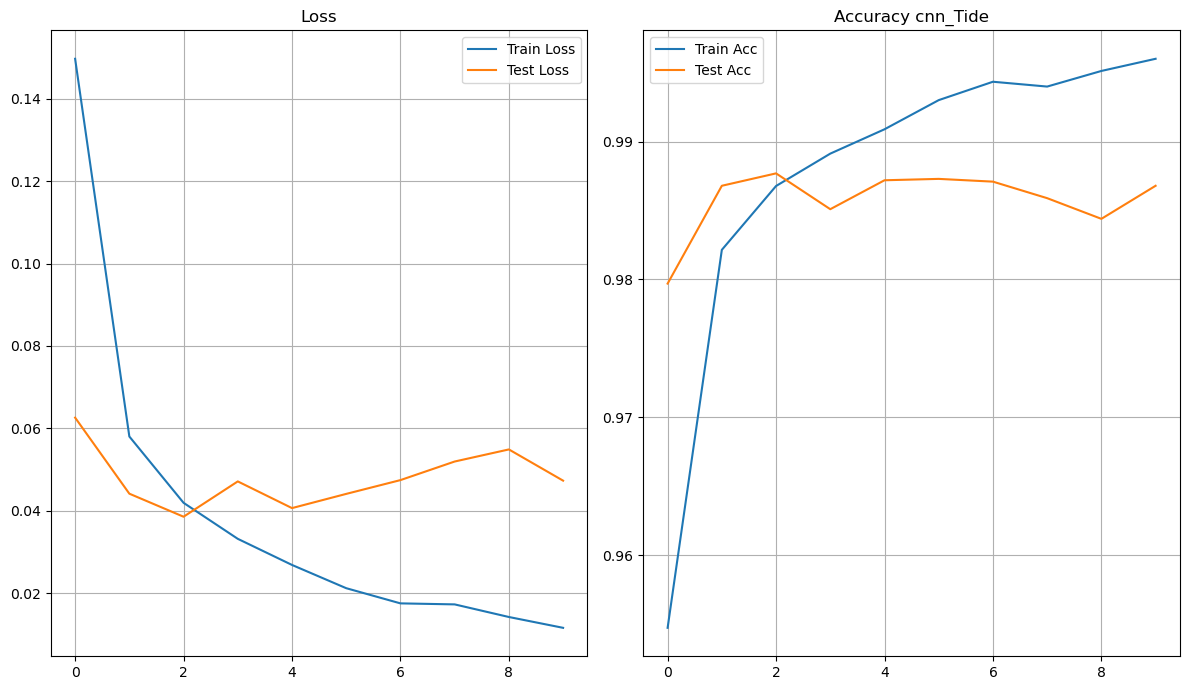

Accuracy cnn_wide_metrics:  Training: 0.9913; test: 0.9943


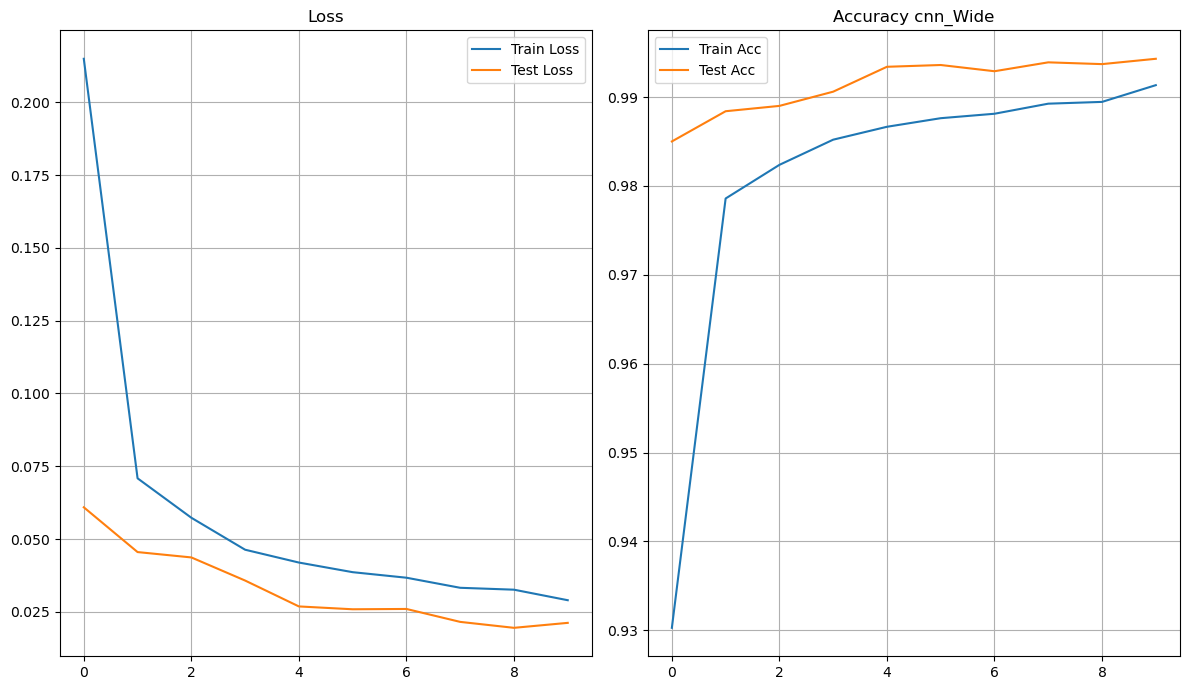

Accuracy cnn_deep_metrics:  Training: 0.9912; test: 0.9948


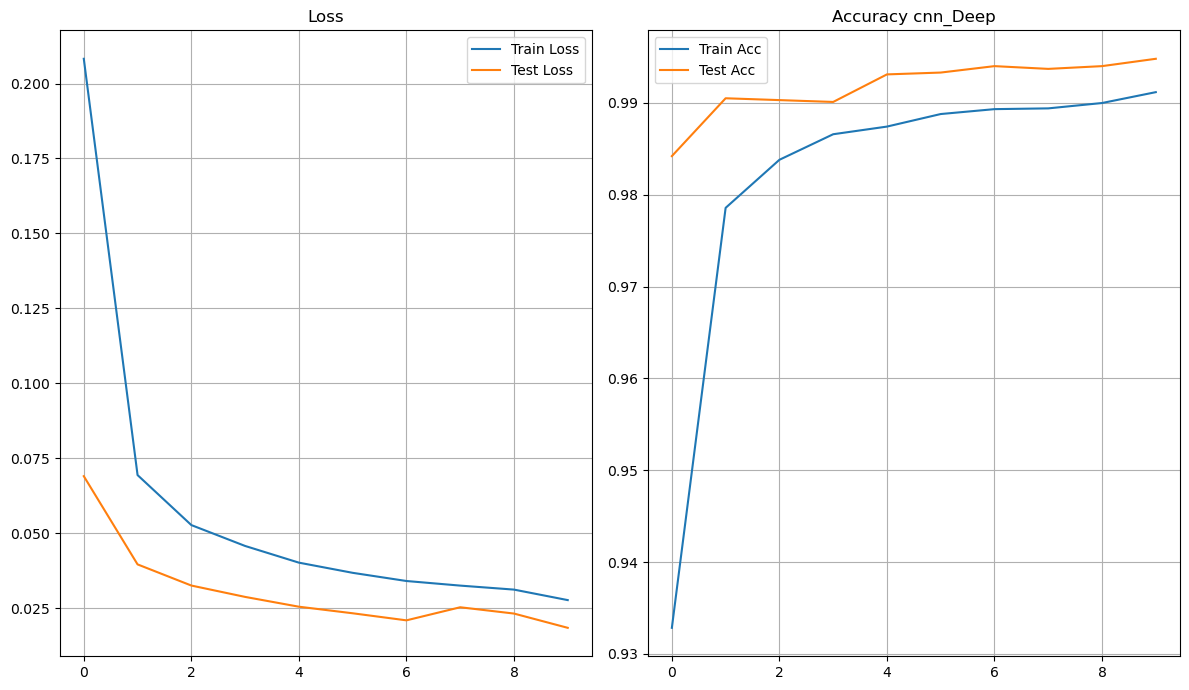

Accuracy resnet_cnn_metrics:  Training: 0.9957; test: 0.9864


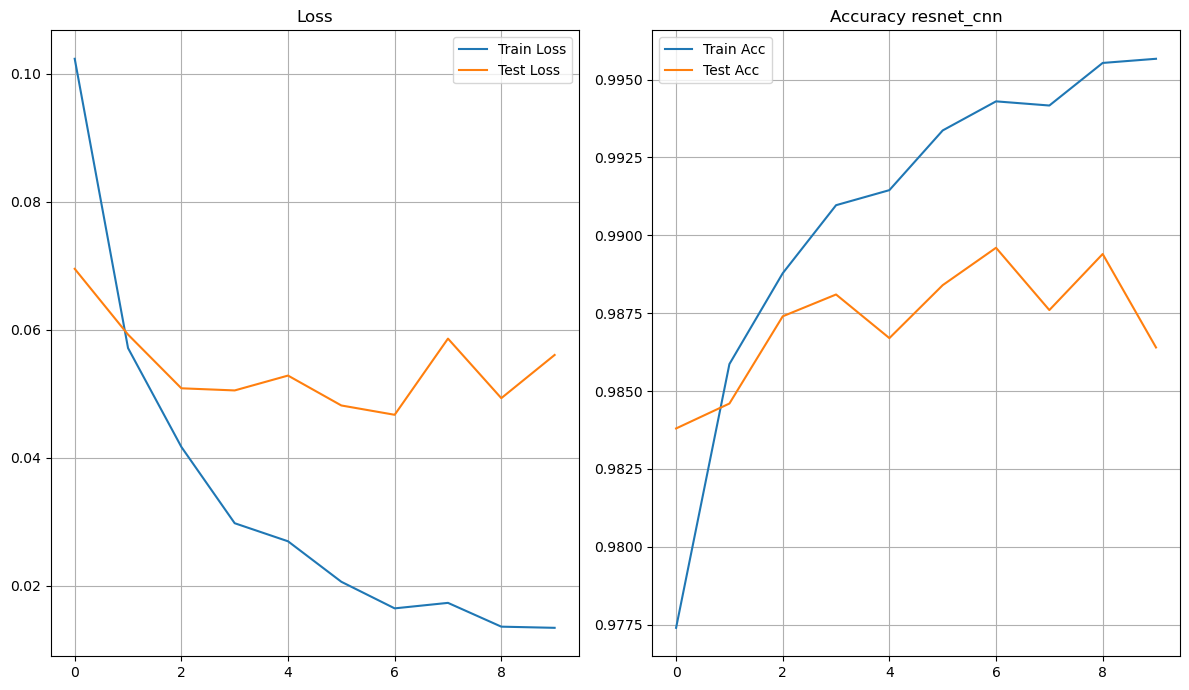

In [293]:
def mean_accr(metric):
    mean_train = metric['train_accs'][-1]
    mean_test = metric['test_accs'][-1]
    return f'Training: {mean_train:.4f}; test: {mean_test:.4f}'

print(f'Accuracy cnn_tide_metrics:  {mean_accr(cnn_tide_metrics)}')
plot_training_history(cnn_tide_metrics, 'cnn_Tide')

print(f'Accuracy cnn_wide_metrics:  {mean_accr(cnn_wide_metrics)}')
plot_training_history(cnn_wide_metrics, 'cnn_Wide')

print(f'Accuracy cnn_deep_metrics:  {mean_accr(cnn_deep_metrics)}')
plot_training_history(cnn_deep_metrics, 'cnn_Deep')

print(f'Accuracy resnet_cnn_metrics:  {mean_accr(resnet_cnn_metrics)}')
plot_training_history(resnet_cnn_metrics, 'resnet_cnn')

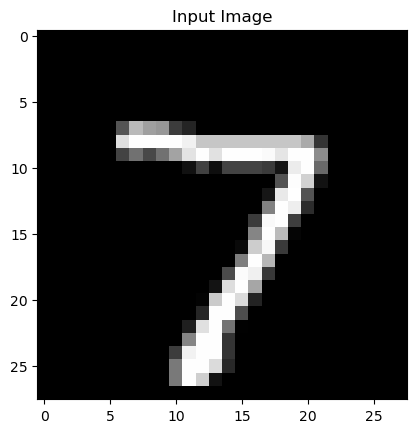

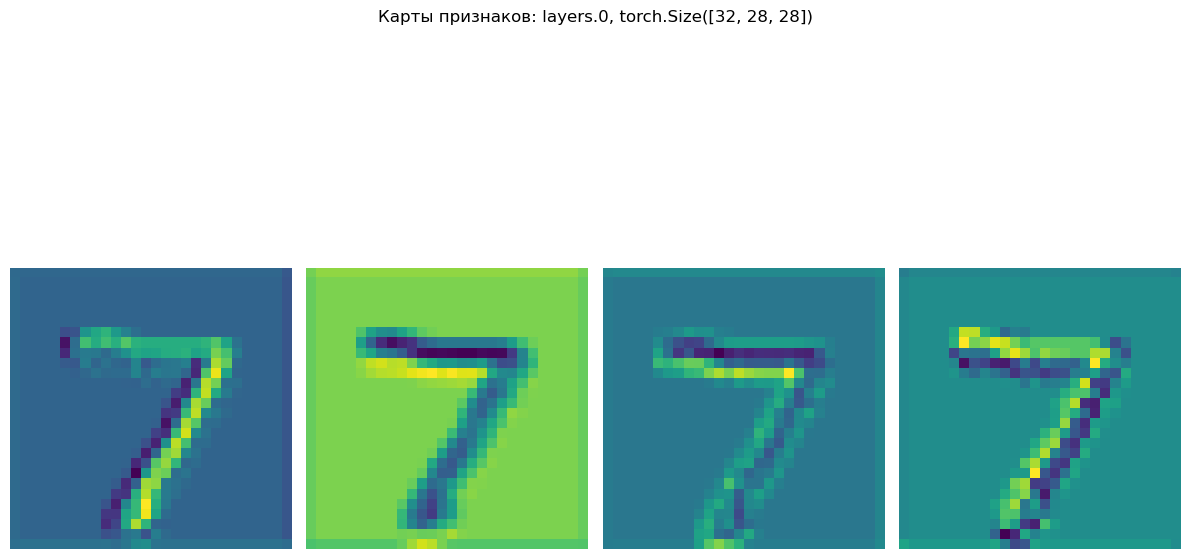

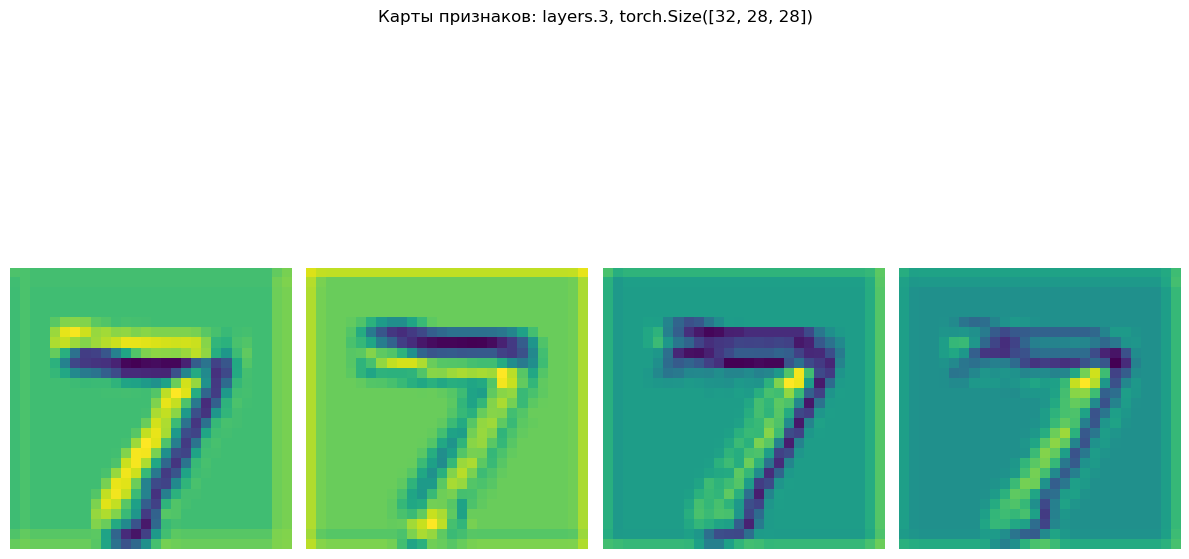

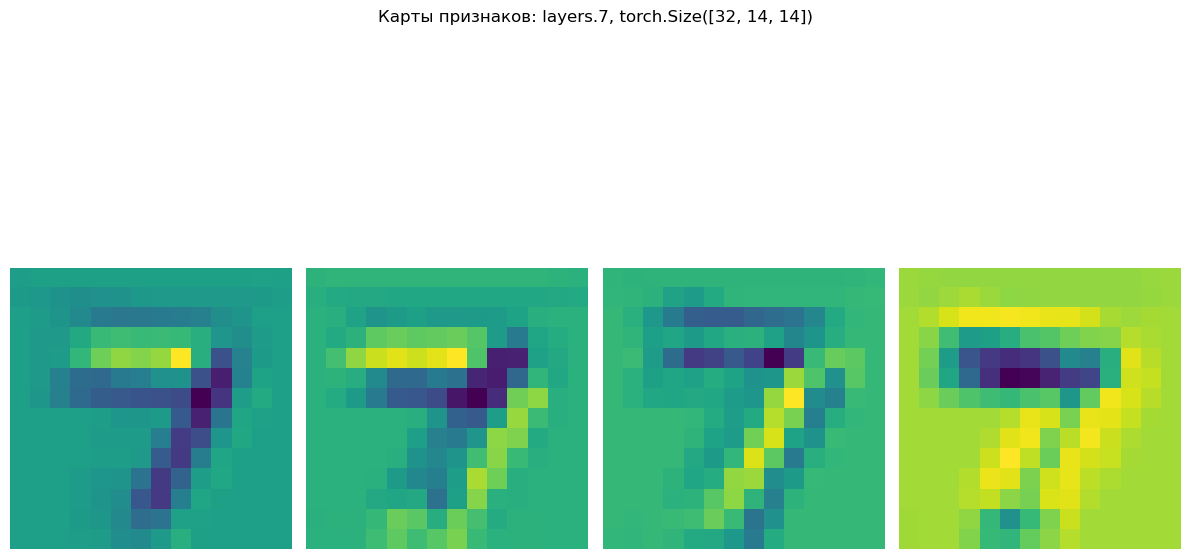

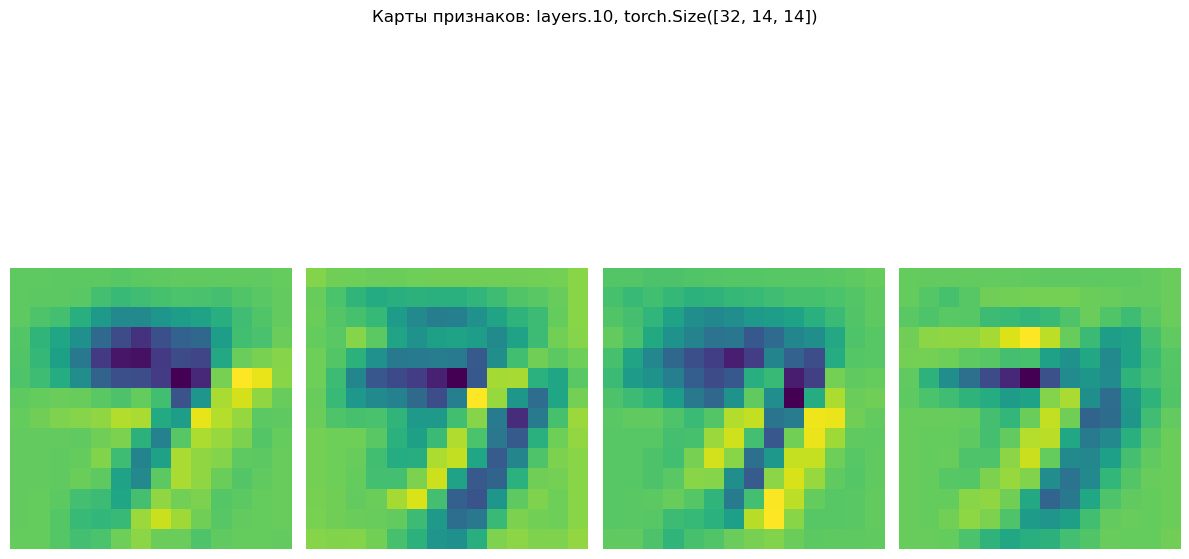

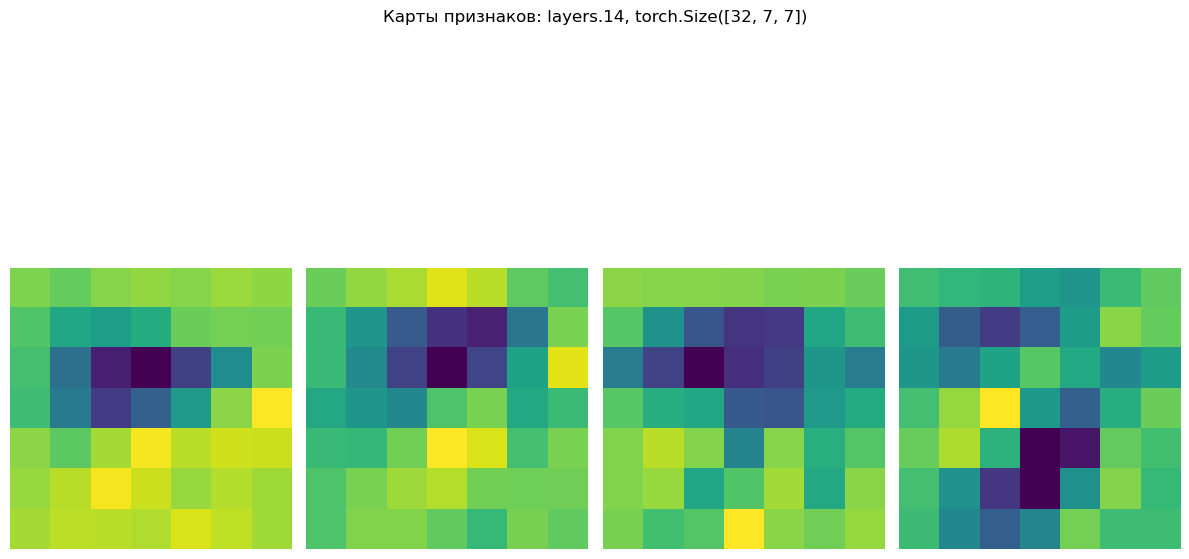

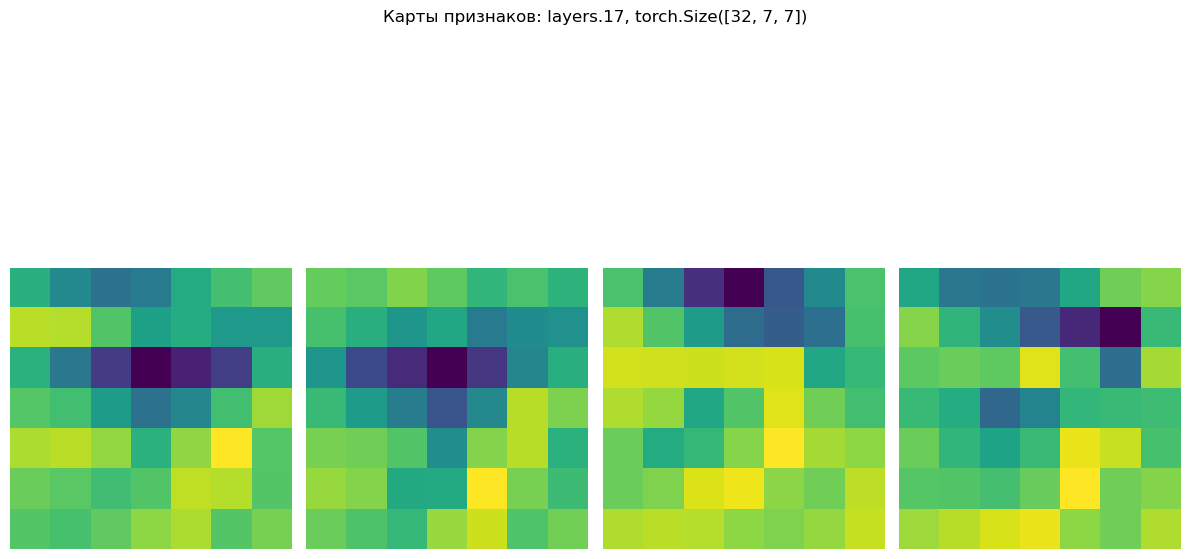

In [309]:
# Используем DeepCNN
extractor = FeatureMapExtractor(cnn_deep)

# Пропускаем изображение через модель
sample_img, _ = next(iter(mnist_test))
sample_img = sample_img[0].unsqueeze(0)  
cnn_deep(sample_img)  

# Визуализация
extractor.visualize(sample_img.squeeze().cpu())

Слой layers.0.weight: grad_mean = 5.14e-03
Слой layers.0.bias: grad_mean = 6.31e-03
Слой layers.3.weight: grad_mean = 6.54e-04
Слой layers.3.bias: grad_mean = 3.49e-03
Слой layers.7.weight: grad_mean = 7.62e-04
Слой layers.7.bias: grad_mean = 4.52e-03
Слой layers.10.weight: grad_mean = 9.25e-04
Слой layers.10.bias: grad_mean = 3.79e-03
Слой layers.14.weight: grad_mean = 1.19e-03
Слой layers.14.bias: grad_mean = 2.61e-03
Слой layers.17.weight: grad_mean = 1.18e-03
Слой layers.17.bias: grad_mean = 2.44e-03
Слой linear.weight: grad_mean = 3.93e-04
Слой linear.bias: grad_mean = 1.73e-03


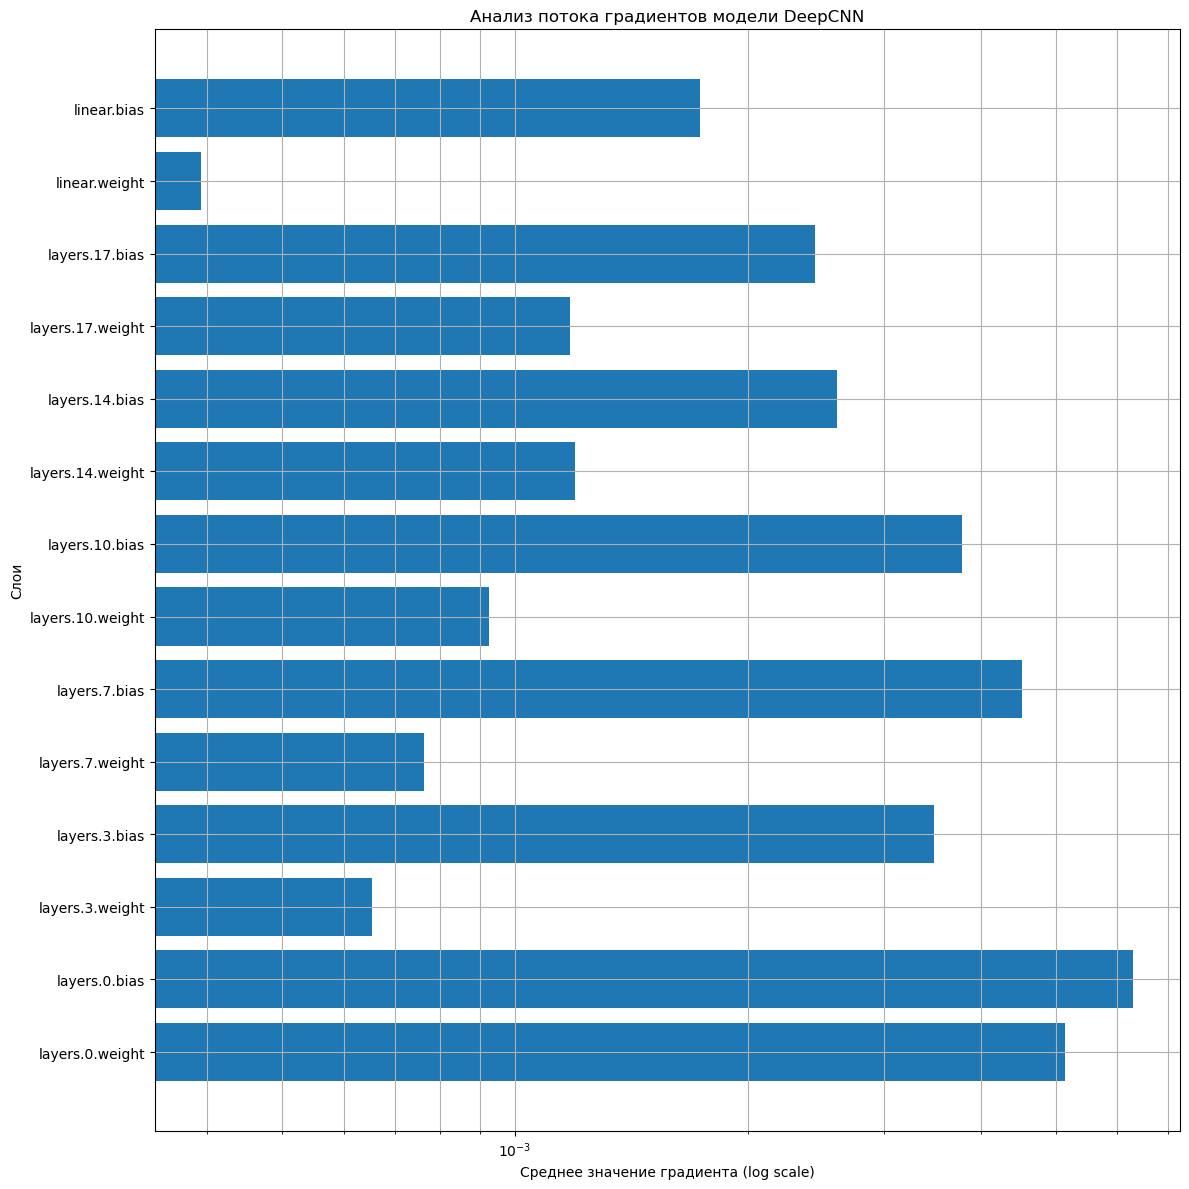

Слой layer1.conv1.weight: grad_mean = 2.23e-03
Слой layer1.bn1.weight: grad_mean = 9.58e-04
Слой layer1.bn1.bias: grad_mean = 6.63e-04
Слой layer1.conv2.weight: grad_mean = 2.13e-04
Слой layer1.bn2.weight: grad_mean = 1.39e-03
Слой layer1.bn2.bias: grad_mean = 1.13e-03
Слой layer1.shortcut.0.weight: grad_mean = 1.09e-06
Слой layer1.shortcut.1.weight: grad_mean = 1.66e-03
Слой layer1.shortcut.1.bias: grad_mean = 1.13e-03
Слой bn1.weight: grad_mean = 4.95e-03
Слой bn1.bias: grad_mean = 2.01e-03
Слой fc.weight: grad_mean = 7.39e-05
Слой fc.bias: grad_mean = 1.04e-03


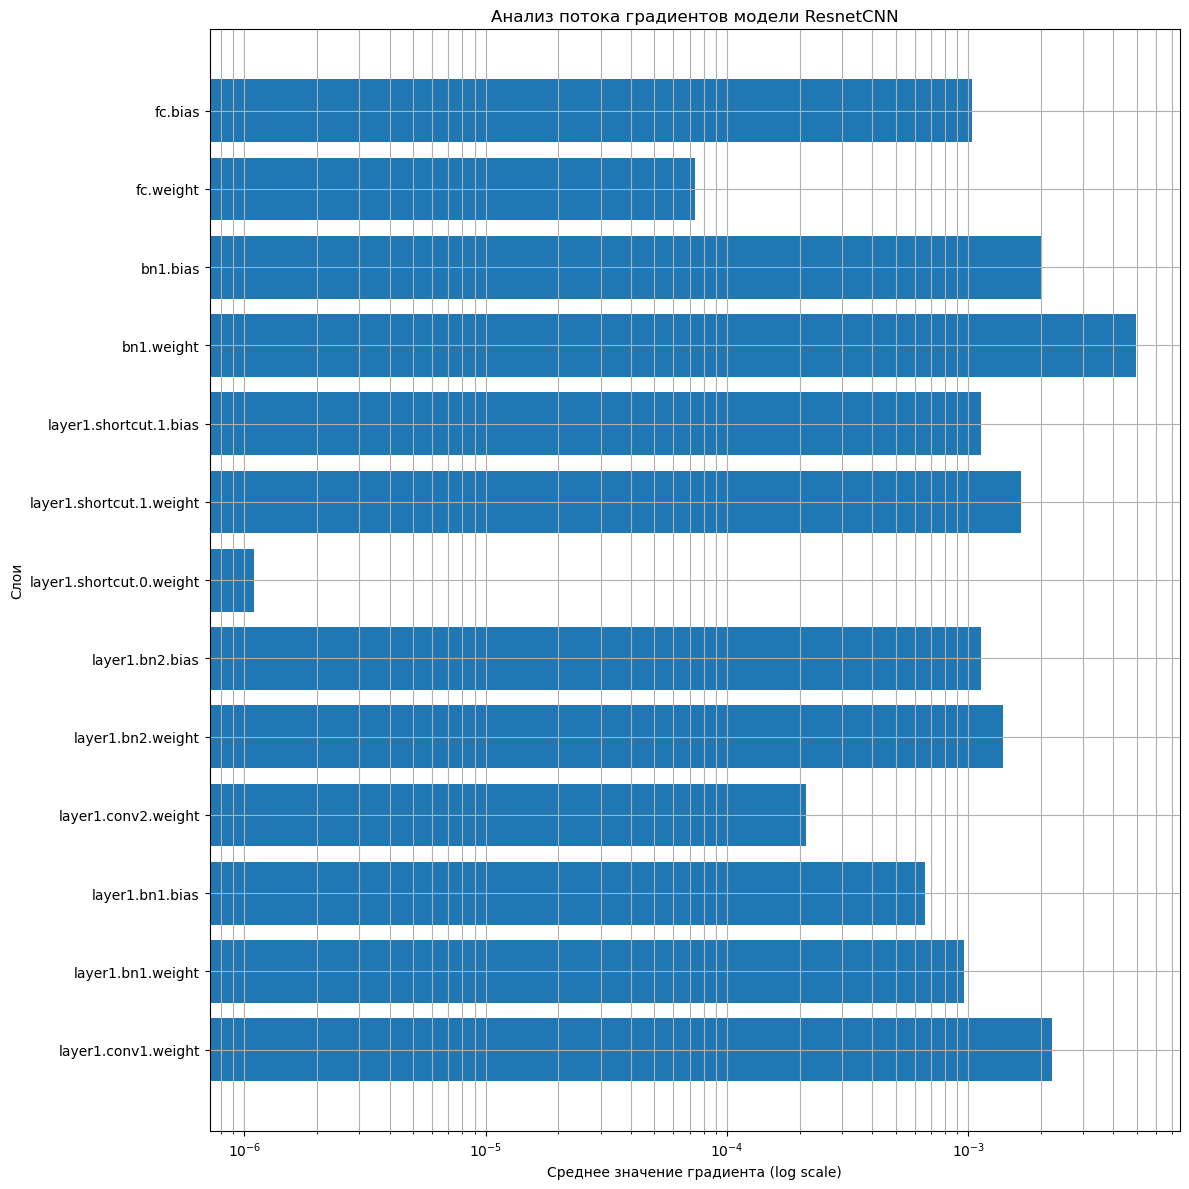

Слой layers.0.weight: grad_mean = 4.04e-03
Слой layers.0.bias: grad_mean = 3.34e-03
Слой layers.3.weight: grad_mean = 5.30e-04
Слой layers.3.bias: grad_mean = 1.64e-03
Слой linear.weight: grad_mean = 2.37e-05
Слой linear.bias: grad_mean = 5.56e-04


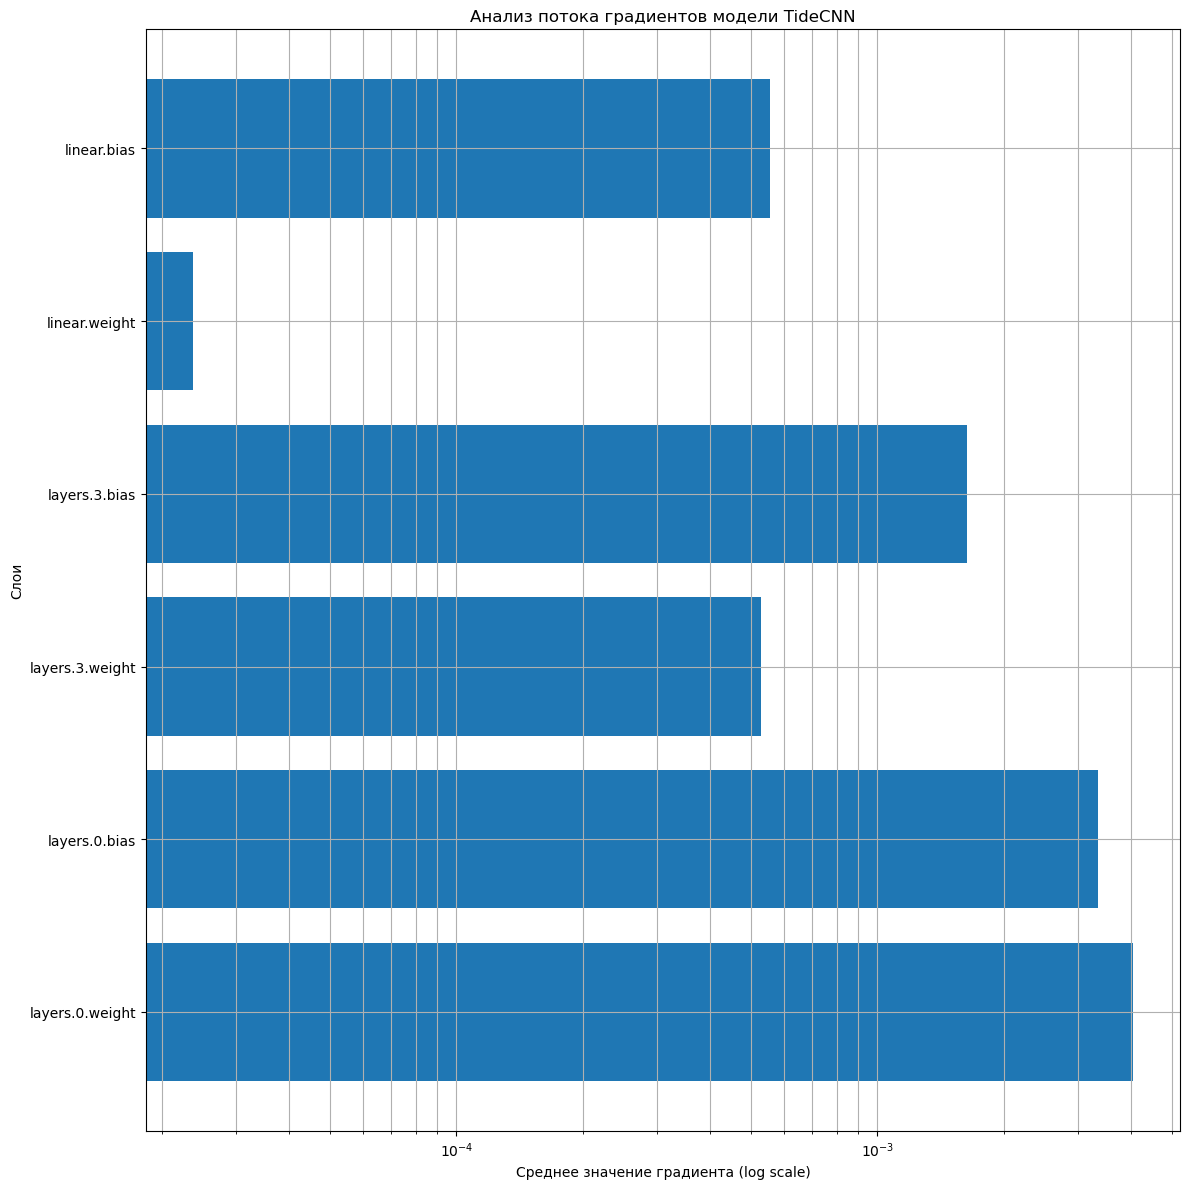

In [322]:
plot_gradient_flow(cnn_deep, mnist_test, 'DeepCNN')
plot_gradient_flow(resnet_cnn, mnist_test, 'ResnetCNN')
plot_gradient_flow(cnn_tide, mnist_test, 'TideCNN')